In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import skimage
import pylab as plt
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.utils as dsutils 
import deepleeo.utils.geofunctions as gf
import deepleeo.networks.model_builder as mb
# from deepleeo.networks import fcn8s

reload(dtaug)
reload(dsutils)
# reload(fcn)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepleeo.utils.geofunctions' from '../src/deepleeo/utils/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real', 'generated')
network = "fcn8s"
DATA_DIR = "/home/raian/doutorado/Dados/generated"
DATASET_FILE = os.path.join(DATA_DIR, 'dataset_286x286_2016.npz')#'dataset_1.npz')
#TODO: Put network name here in the path
# model_dir = os.path.join(DATA_DIR, 'tf_logs', "test_%s_%s" % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
# model_dir = "/home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug"
model_dir = os.path.join(DATA_DIR, 'tf_logs', 'test_fcn8s_24_10_2018-19_09_09')

In [3]:
# raster_path = os.path.join(DATA_DIR, "..", "Landsat8_225064_17072016_R6G5B4_clip.tif")
# raster_path = os.path.join(DATA_DIR, "mosaic_2016.tif")
raster_path = os.path.join(DATA_DIR, 'stacked_mosaic_2015_2016.tif')

In [4]:
dataset = np.load(DATASET_FILE)

print("Data Loaded:")
print("  -> Images: ", len(dataset["images"]))
print("  -> Labels: ", len(dataset["labels"]))
print("  -> Classes: ", len(dataset["classes"]))

print("Images shape: ", dataset["images"][0].shape, " - DType: ", dataset["images"][0].dtype)
print("Labels shape: ", dataset["labels"][0].shape, " - DType: ", dataset["labels"][0].dtype)
# print("UNIQUE LABELS: ", np.unique(dataset["labels"]))

Data Loaded:
  -> Images:  5000
  -> Labels:  5000
  -> Classes:  2
Images shape:  (286, 286, 5)  - DType:  float32
Labels shape:  (286, 286, 1)  - DType:  int32


# Perform Data Augmentation

In [ ]:
reload(dtaug)
angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images(dataset["images"], angles)
flipped_imgs = dtaug.flip_images(dataset["images"])

new_dataset = {}
new_dataset["images"] = np.concatenate((dataset["images"], rotated_imgs))
new_dataset["images"] = np.concatenate((new_dataset["images"], flipped_imgs))

rotated_lbls = dtaug.rotate_images(dataset["labels"], angles)
flipped_lbls = dtaug.flip_images(dataset["labels"])

new_dataset["labels"] = np.concatenate((dataset["labels"], rotated_lbls))
new_dataset["labels"] = np.concatenate((new_dataset["labels"], flipped_lbls)).astype(dtype=np.int32)

new_dataset["classes"] = dataset["classes"]

print("Data Augmentation Applied:")
print("  -> Images: ", new_dataset["images"].shape)
print("  -> Labels: ", new_dataset["labels"].shape)

# Split dataset between train, test and validation data

In [ ]:
train_images, test_images, valid_images, train_labels, test_labels, valid_labels = dsutils.split_dataset(dataset)

print("Splitted dataset:")
print("  -> Train images: ", train_images.shape)
print("  -> Test images: ", test_images.shape)
print("  -> Validation images: ", valid_images.shape)
print("  -> Train Labels: ", train_labels.shape)
print("  -> Test Labels: ", test_labels.shape)
print("  -> Validation Labels: ", valid_labels.shape)

# Train the Network

In [5]:
params = {
    "epochs": 2,
    "batch_size": 200,
    "learning_rate": 0.0001,
    "class_names": dataset["classes"],
    "multi_gpu": False
}

In [ ]:
# reload(fcn)
reload(mb)

model = mb.ModelBuilder(network)
model.train(train_images, test_images, train_labels, test_labels, params, model_dir)

In [ ]:
#fcn.fcn_evaluate(valid_images, valid_labels,)

In [6]:
import deepleeo.dataset.preprocessor as prep
import dataset.sequencialchips as seqchips

reload(gf)
reload(prep)
reload(seqchips)
# print(raster_path)

preproc = prep.Preprocessor(raster_path, no_data=-9999)
raster_array = preproc.standardize_image()
chips = seqchips.generate_sequential_chips(raster_array, chip_size=286)#, overlap=(93, 93))

/home/raian/doutorado/Dados/generated/stacked_mosaic_2015_2016.tif


/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


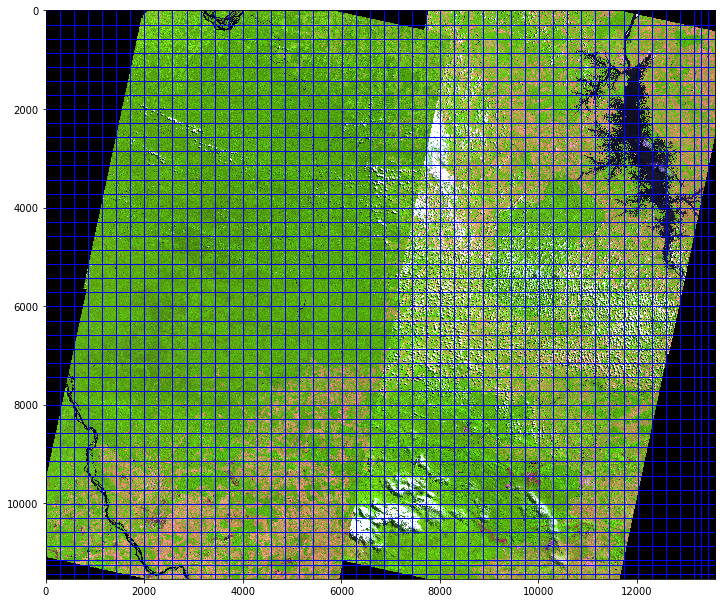

In [7]:
reload(seqchips)
original_raster = gf.load_image(raster_path, 0)
seqchips.plot_chips(chips, original_raster, bands=[3, 2, 1], contrast=True)

In [8]:
reload(mb)

trained_model = "/home/raian/doutorado/Dados/generated/tf_logs/test_fcn8s_24_10_2018-19_09_09"

model = mb.ModelBuilder(network)
predictions = model.predict(chips["chips"], params=params, model_dir=trained_model)
out_pred = chips.copy()
out_pred["chips"] = predictions.copy()

Classifying image with structure  (1968, 286, 286, 10) ...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/Dados/generated/tf_logs/test_fcn8s_24_10_2018-19_09_09/model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [9]:
import gdal
import osr
reload(seqchips)

output_path = os.path.join(DATA_DIR, "prediction.tiff")
    
seqchips.write_chips(output_path, raster_path, out_pred)

In [10]:
new_ds = gdal.Open(output_path)
rarr = new_ds.ReadAsArray()

# print(np.unique(rarr))

# import deepleeo.utils.visualization as vis
# reload(vis)

# print("MIN: ", np.min(rarr))
# print("MAX: ", np.max(rarr))

# vis.plot_image_histogram(rarr, title = "prediction")

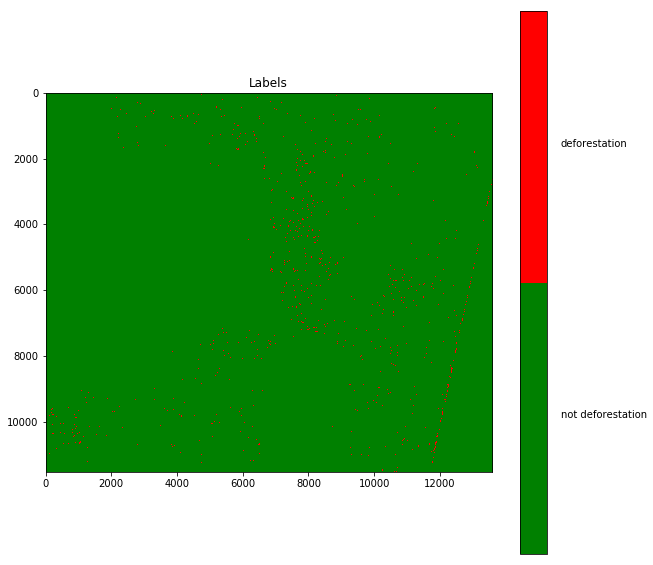

In [11]:
import deepleeo.utils.visualization as vis
reload(vis)
vis.plot_labels(rarr, ["not deforestation", "deforestation"], colors=["green", "red"])